In [215]:
import tensorflow as tf
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import math

In [127]:
# Just get the images we need
style_img = Image.open('images/african_art_2.jpg')

# Remember, numpy arrays of images is height x width x channels (RGB)
style_array = np.array(style_img)

# Make the channels first 
#style_array = np.rollaxis(style_array, 2, 0)

# Do the same with the content image
content_img = Image.open('images/owl_on_branch.jpg')
content_array = np.array(content_img)

# Define a variable to storing the shape of the images
SHAPE = content_array.shape

# Make channels first for content array
#content_array = np.rollaxis(content_array, 2, 0)

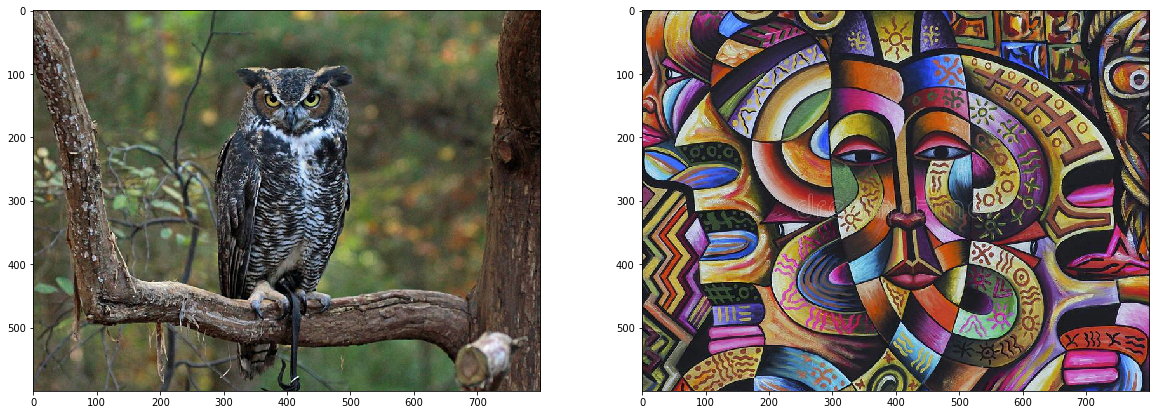

In [128]:
# Show the images
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(content_img)

plt.subplot(1, 2, 2)
plt.imshow(style_img)

In [129]:
# Shows images when the channel is first
def imshow_channels_first(image):
    plt.figure(figsize=(10, 5))
    plt.imshow(np.rollaxis(image[0], 0, 3))

def imshow_channels_last(image):
    plt.figure(figsize=(10, 5))
    plt.imshow(image[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


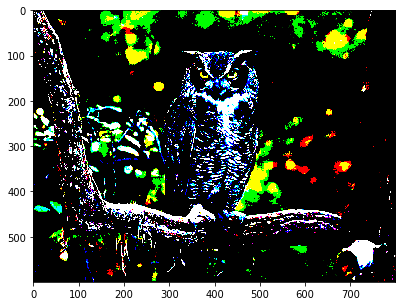

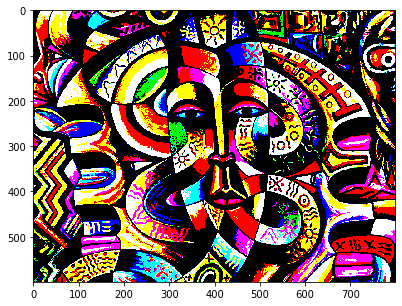

In [130]:
# Normalize the image
def normalization(image):
    vgg_means = [123.68, 116.779, 103.94]
    ret_img = image.astype(dtype=np.float32)
    ret_img[:, :, 0] = ret_img[:, :, 0] - vgg_means[0]
    ret_img[:, :, 1] = ret_img[:, :, 1] - vgg_means[1]
    ret_img[:, :, 2] = ret_img[:, :, 2] - vgg_means[2]
    return ret_img

# Add a 1 to the beginning of the matrix to act as the batch size
norm_content_array = np.expand_dims(normalization(content_array), axis=0)
norm_style_array = np.expand_dims(normalization(style_array), axis=0)

# Show the images
imshow_channels_last(norm_content_array)
imshow_channels_last(norm_style_array)

In [123]:
# Test that VGG19 works
vgg_test = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg_test(tf.image.resize(norm_content_array, (224, 224)))
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('great_grey_owl', 0.8240277),
 ('kite', 0.14469773),
 ('ruffed_grouse', 0.020620828),
 ('bald_eagle', 0.0034809767),
 ('black_grouse', 0.002178383)]

In [131]:
# Define the VGG19 model
vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet", pooling = "avg", input_shape = SHAPE)

In [132]:
# Layers to use when computing the cost
CONTENT_LAYERS = [
    ('block4_conv2', 0.2),
]

STYLE_LAYERS = [
    ('block1_conv2', 0.2),
    ('block2_conv2', 0.2),
    ('block3_conv2', 0.2),
    ('block4_conv2', 0.2),
    ('block5_conv2', 0.2)
]

In [133]:
# Create a model for 
def vgg_model_output(layers):
    layer_outputs = []
    for layer, weight in layers:
        layer_outputs.append(vgg.get_layer(layer).output)
    return tf.keras.Model([vgg.input], layer_outputs)

In [137]:
# Create the variables for the style hidden layers and the content hidden layers
content_activations = vgg_model_output(CONTENT_LAYERS)(norm_content_array)
style_activations = vgg_model_output(STYLE_LAYERS)(norm_style_array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


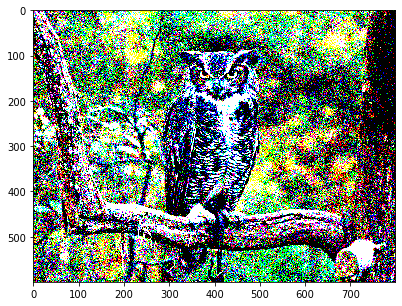

In [198]:
def add_noise_to_img(image):
    mean = 30.0
    std = 30.0
    return image + np.random.normal(mean, std, image.shape)

imshow_channels_last(add_noise_to_img(norm_content_array))

In [232]:
class VGG_Prop(tf.keras.Model):
    def __init__(self):
        super(VGG_Prop, self).__init__()
        self.gen_img = tf.Variable(add_noise_to_img(norm_content_array), name="gen_img", dtype=tf.float32)
        
    def forward_pass_vgg_content(self):
        return vgg_model_output(CONTENT_LAYERS)(self.gen_img)
    
    def forward_pass_vgg_style(self):
        return vgg_model_output(STYLE_LAYERS)(self.gen_img)
    
    def compute_content_cost(self):
        # Compute the content cost 
        # * Can confirm this works
        gen_img_content_activations = self.forward_pass_vgg_content()
        m, n_H, n_W, n_C = gen_img_activations.get_shape().as_list()
        
        unrolled_content_activations = tf.reshape(content_activations[0], [m, n_W * n_H, n_C])
        unrolled_gen_img_content_activations = tf.reshape(gen_img_content_activations[0], [m, n_W * n_H, n_C])
        
        return (1/(4 * n_W * n_H * n_C)) * tf.math.reduce_sum(tf.math.square(tf.subtract(unrolled_content_activations, unrolled_gen_img_content_activations)))
    
    def compute_gram(self, matrix):
        return tf.matmul(matrix, tf.transpose(matrix))
    
    def style_layer_cost(self, gen_img_layer_activation, style_layer_activation):
        # Retrieve the dimensions from the activations
        m, n_H, n_W, n_C = gen_img_layer_activation.get_shape().as_list()
        
        gen_img_layer_activation = tf.reshape(tf.transpose(gen_img_layer_activation, perm=[3, 1, 2, 0]), shape=[n_C, -1])
        style_layer_activation = tf.reshape(tf.transpose(style_layer_activation, perm=[3, 1, 2, 0]), shape=[n_C, -1])
        
        gen_gram = self.compute_gram(gen_img_layer_activation)
        style_gram = self.compute_gram(style_layer_activation)
        
        return (1/(4 * n_C**2 * (n_H * n_W)**2)) * tf.math.reduce_sum(tf.math.square(tf.math.subtract(style_gram, gen_gram)))
    
    def style_total_cost(self):
        gen_img_style_activations = self.forward_pass_vgg_style()
        total_cost = 0.0
        for layer in range(0, len(gen_img_style_activations)):
            total_cost = tf.add(total_cost, tf.math.multiply(STYLE_LAYERS[layer][1], self.style_layer_cost(gen_img_style_activations[layer], style_activations[layer])))
            
        return total_cost
    
    def call(self):
        return 
        


In [233]:
x = VGG_Prop()


tf.Tensor(3774037800.0, shape=(), dtype=float32)
